In [1]:
import datetime
from datetime import date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import statsmodels.api as sm

In [2]:
def fill_time_point(dataframe):
    df = dataframe.copy()
    
    i = 0
    curr = df.index[0]
    end = df.index[-1]

    while curr != end:
        curr += datetime.timedelta(days=1)
        i+=1
        if curr != df.index[i]:
            before = df.iloc[i-1].to_numpy().copy()
            after = df.iloc[i].to_numpy().copy()
            days_missed = (df.index[i] - curr).days
            avg = ((after - before)/(days_missed+1)).round(1)

            while curr != df.index[i]:
                before += avg
                fix = pd.DataFrame({'Open': before[0], 'High': before[1], 'Low': before[2], 'Close': before[3]}, index=[curr])
                df = df.append(fix)
                #print(fix)
                curr += datetime.timedelta(days=1)

    df.sort_index(inplace=True)
    return df

In [3]:
def read_the_fill_csv(filepath):
    df = pd.read_csv(filepath, parse_dates={'Datetime':['Date']}).iloc[::-1]
    df.set_index(['Datetime'], inplace = True)
    df_filled = fill_time_point(df)
    
    return df, df_filled

In [4]:
BVH, BVH_filled = read_the_fill_csv('BVH.csv')
BVH.shape, BVH_filled.shape

((2868, 4), (4193, 4))

### Used from here

In [5]:
BVH

,Open,High,Low,Close
Datetime,,,,
2009-06-25,46.2,46.2,45.0,46.2
2009-06-26,48.5,48.5,48.0,48.5
2009-06-29,50.5,50.5,50.5,50.5
2009-06-30,53.0,53.0,53.0,53.0
2009-07-01,50.5,51.5,50.5,50.5
...,...,...,...,...
2020-12-10,57.9,58.0,56.5,56.7
2020-12-11,56.7,57.5,56.0,57.5
2020-12-14,58.0,59.4,57.3,58.6


In [6]:
BVH.dtypes

Open     float64
High     float64
Low      float64
Close    float64
dtype: object

#### Visualization

In [7]:
from datetime import date, timedelta
available = BVH.index
date_set = set(available[0] + timedelta(x) for x in range((available[-1] - available[0]).days))
missing = sorted(date_set - set(available))

In [8]:
available_df = BVH.reindex(date_set).sort_index()
missing_df = BVH_filled.loc[missing].reindex(date_set).sort_index()

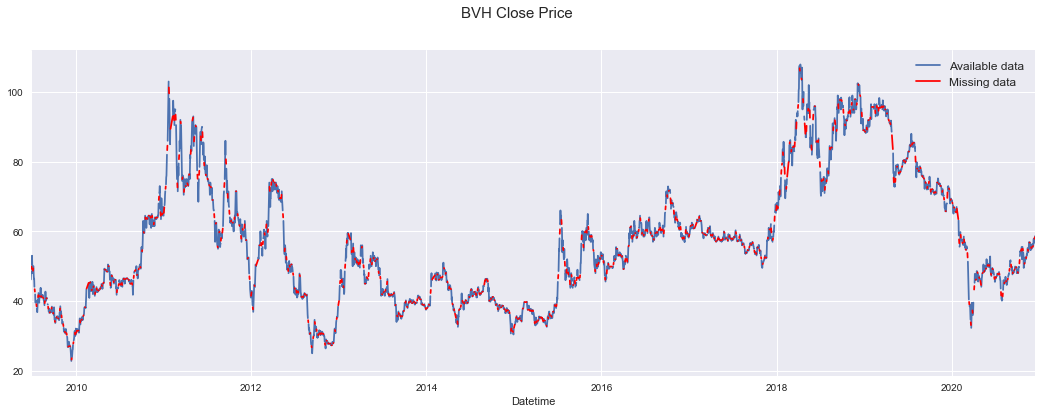

In [9]:
fig, axes = plt.subplots(figsize=(18, 6))

ax1 = available_df['Close'].plot(label='Available data')
ax1.legend(fontsize=12)

ax2 = missing_df['Close'].plot(color='red', label='Missing data')
ax2.legend(fontsize=12)

fig.suptitle('BVH Close Price', fontsize=15)
plt.show()

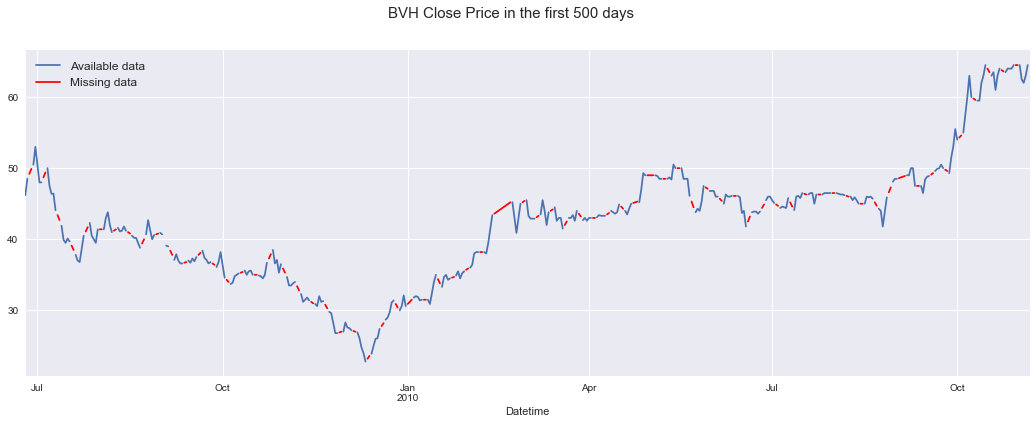

In [10]:
fig, axes = plt.subplots(figsize=(18, 6))

ax1 = available_df.head(500)['Close'].plot(label='Available data')
ax1.legend(fontsize=12)

ax2 = missing_df.head(500)['Close'].plot(color='red', label='Missing data')
ax2.legend(fontsize=12)

fig.suptitle('BVH Close Price in the first 500 days', fontsize=15)
plt.show()

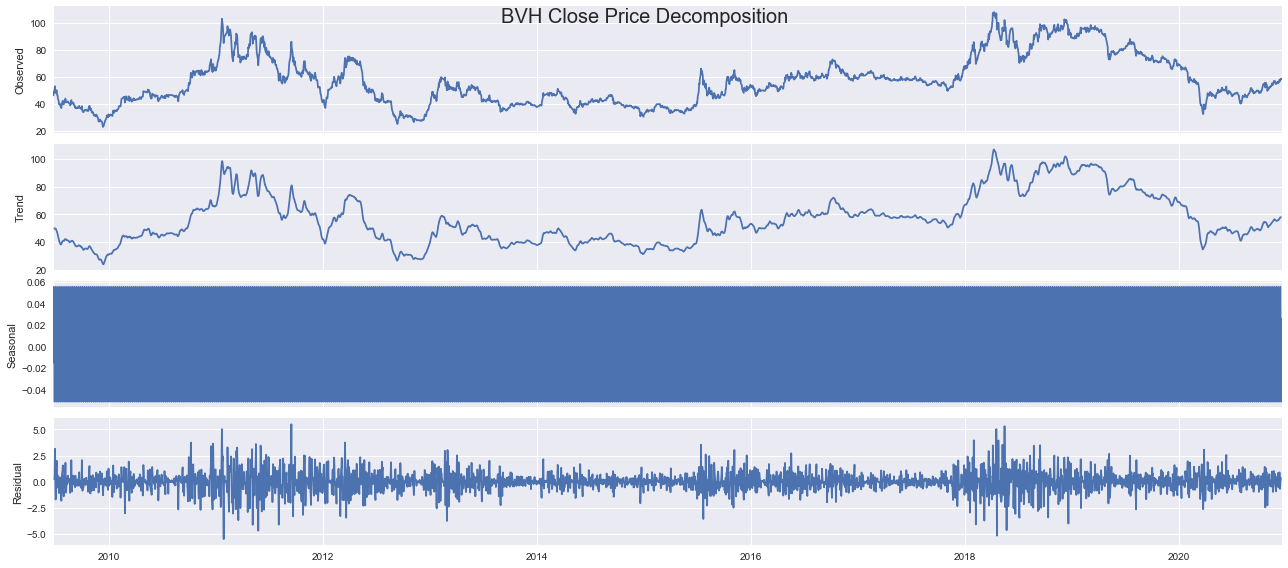

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(BVH_filled['Close'], model = 'additive')
fig = decomposition.plot()
fig.suptitle('BVH Close Price Decomposition', fontsize=20)
plt.show()

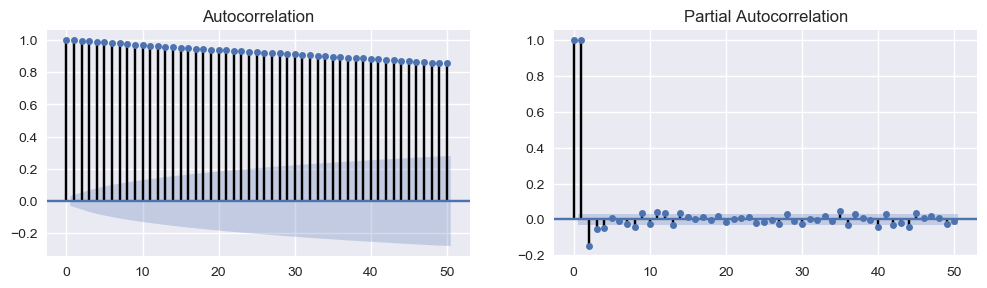

In [12]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), dpi=100)
plot_acf(BVH_filled['Close'].values.tolist(), lags=50, ax=axes[0])
plot_pacf(BVH_filled['Close'].values.tolist(), lags=50, ax=axes[1])
plt.show()